In [1]:
'''
Model: DreNet 
Aplpiance: microwave
Data: Redd

Method:S2P
Normalization: no norm
batch_size: 128,
window_size: 100
shuffle: True

num epochs=50
'''

'\nModel: DreNet \nAplpiance: microwave\nData: Redd\n\nMethod:S2P\nNormalization: no norm\nbatch_size: 128,\nwindow_size: 100\nshuffle: True\n\nnum epochs=50\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'drive/My Drive/Dissertation')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
pip install git+git://github.com/nilmtk/nilmtk.git

  Cloning git://github.com/nilmtk/nilmtk.git to /tmp/pip-req-build-k1qdxwcm
  Running command git clone -q git://github.com/nilmtk/nilmtk.git /tmp/pip-req-build-k1qdxwcm
     |████████████████████████████████| 2.9MB 6.4MB/s 
     |████████████████████████████████| 1.6MB 38.0MB/s 
     |████████████████████████████████| 153kB 39.4MB/s 
     |████████████████████████████████| 337kB 39.4MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-1du15d9l/wheels/71/84/2f/eca0fb8014a0fe59881ab1a3e3374f4108211de4c7c3081e8d
  Stored in directory: /root/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e
  Stored in directory: /root/.cache/pip/wheels/2c/b6/0e/63a865a30e21e01d04f417d8995fbfb793d6bd464707efc546
Successfully built nilmtk networkx hmmlearn
ERROR: ipython 5.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 2.0.9 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 

In [4]:
pip install git+git://github.com/nilmtk/nilm_metadata.git

  Cloning git://github.com/nilmtk/nilm_metadata.git to /tmp/pip-req-build-_bts885m
  Running command git clone -q git://github.com/nilmtk/nilm_metadata.git /tmp/pip-req-build-_bts885m
  Stored in directory: /tmp/pip-ephem-wheel-cache-ykolg1v3/wheels/75/e0/6d/1ec555a322c151fe20b4c9834753a692203b1f62a66b3ee235
Successfully built nilm-metadata


In [5]:
pip install pandas==0.24.0

     |████████████████████████████████| 10.1MB 6.3MB/s 
ERROR: nilmtk 0.3.0.dev0+git.6ddeff9 has requirement pandas==0.24.2, but you'll have pandas 0.24.0 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [0]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore


import random
import sys
import pandas as pd
import numpy as np
import h5py



def load_dataset(window_per_house,test_window, filename, meter_label, train_building, test_building, **load_kwargs):
    
    #Load datasets
    train = DataSet(filename)
    test = DataSet(filename)

    #train.set_window(start=start_train, end=end_train)
    test.set_window(*test_window[test_building])

    train_mainlist = []
    train_meterlist = []
    for building_id, building in train.buildings.items():
        if building_id in train_building:
            train.set_window(*window_per_house[building_id])
            y = building.elec[meter_label]
            
            if filename[-7:] == 'redd.h5':
                x = building.elec.mains().all_meters()[0] 
                
            else:
                x = building.elec.mains()
                
            train_mainlist.append(x.power_series_all_data(**load_kwargs))
            train_meterlist.append(y.power_series_all_data(**load_kwargs))
            

    test_meterlist = test.buildings[test_building].elec[meter_label]
    
    if filename[-7:] == 'redd.h5':
        test_mainlist = test.buildings[test_building].elec.mains().all_meters()[0]
    else:
        test_mainlist = test.buildings[test_building].elec.mains()

    assert len(train_mainlist) == len(train_meterlist), "The number of main and apliances meters must be equal"

    return train_meterlist, train_mainlist, test_meterlist, test_mainlist


def data_processing(train_mainlist, train_meterlist, window_size):
    '''Data processing

    Parameters
    ----------
    train_mainlist : a list of nilmtk.ElecMeter objects for the aggregate data of each building
    train_meterlist : a list of nilmtk.ElecMeter objects for the meter data of each building
    '''

    # Normalize the data
    norm = Data_normalization()
    train_x = [norm.standardise(data) for data in train_mainlist]
    train_y = [norm.normalise(data) for data in train_meterlist]
    
    #train_x = [data for data in train_mainlist]
    #train_y = [data for data in train_meterlist]

    # replca NaN values and
    for i in range(len(train_x)):
        train_x[i].fillna(0, inplace=True)
        train_y[i].fillna(0, inplace=True)
        ix = train_x[i].index.intersection(train_y[i].index)

        train_x[i] = train_x[i][ix].values
        train_y[i] = train_y[i][ix].values

    return train_x, train_y, norm



# def normalise(data):
#     """
#     Perform the normalisation (x-min(x))/(max(x)-min(x)).
#     --------------------------------------
#     :arg
#     data: data that needs to be transformed
#     mean: mean value of data
#     max_v: max value of data
#     :return
#     The normalized data
#     """
# #     std =np.std(data)
# #     mean = data.mean()
# #     max_v = data.max()

#     return data/4505.783 #remember to try this normalization as well
#     #return (data - mean) / (max_v-mean)


# def inversenormalise(data):
#     """
#     Perform the in-normalisation data*(max(x)-min(x))+min(x).
#     ------------------------------------------------
#     :arg
#     data: data that needs to be inverse-transformed
#     mean: mean value of data
#     max_v: max value of data
#     :return
#     The in-normalized data
#     """
# #     std =np.std(data)
# #     mean = data.mean()
# #     max_v = data.max()
    
#     return data * 4505.783

    #return data * (max_v-mean) + mean

# def standardise(X, how='std=1', mean=None, std=None, midrange=None,
#                 ptp=None):
#     """Standardise.
#     ftp://ftp.sas.com/pub/neural/FAQ2.html#A_std_in
#     Parameters
#     ----------
#     X : matrix
#         Each sample is in range [0, 1]
#     how : str, {'range=2', 'std=1'}
#         'range=2' sets midrange to 0 and enforces
#         all values to be in the range [-1,1]
#         'std=1' sets mean = 0 and std = 1
#     Returns
#     -------
#     new_X : matrix
#         Same shape as `X`.  Sample is in range [lower, upper]
#     See also
#     --------
#     unstandardise
#     """
#     if how == 'std=1':
#         if mean is None:
#             mean = X.mean()
#         if std is None:
#             std = X.std()
#         centered = X - mean
#         if std == 0:
#             return centered
#         else:
#             return centered / std
#     elif how == 'range=2':
#         if midrange is None:
#             midrange = (X.max() + X.min()) / 2
#         if ptp is None:
#             ptp = X.ptp()
#         return (X - midrange) / (ptp / 2)
#     else:
#         raise RuntimeError("unrecognised how '" + how + "'")
        
# def unstandardise(data, std=None, mean=None, maximum=None):
#     unstandardised_data = (data * std) + mean
#     if maximum is not None:
#         unstandardised_data *= maximum
#     return unstandardised_data

In [0]:
class Data_normalization():
  
  
  def __init__(self, mean=None, std=None, maxx=None):
        '''Initialize 
        '''
        self.mean = mean
        self.std = std
        self.max = maxx
        
  def normalise(self,data):
    if self.max is None:
      self.max = data.max()
    return data/self.max
  
  def inversenormalise(self,data):
    
    return data*self.max


  def standardise(self,X, how='std=1', midrange=None,
                  ptp=None):
      """Standardise.
      ftp://ftp.sas.com/pub/neural/FAQ2.html#A_std_in
      Parameters
      ----------
      X : matrix
          Each sample is in range [0, 1]
      how : str, {'range=2', 'std=1'}
          'range=2' sets midrange to 0 and enforces
          all values to be in the range [-1,1]
          'std=1' sets mean = 0 and std = 1
      Returns
      -------
      new_X : matrix
          Same shape as `X`.  Sample is in range [lower, upper]
      See also
      --------
      unstandardise
      """
      if how == 'std=1':
          if self.mean is None:
              self.mean = X.mean()
          if self.std is None:
              self.std = X.std()
          centered = X - self.mean
          if self.std == 0:
              return centered
          else:
              return centered / self.std
      elif how == 'range=2':
          if midrange is None:
              midrange = (X.max() + X.min()) / 2
          if ptp is None:
              ptp = X.ptp()
          return (X - midrange) / (ptp / 2)
      else:
          raise RuntimeError("unrecognised how '" + how + "'")

  def unstandardise(self, data, maximum=None):
      unstandardised_data = (data * self.std) + self.mean
      if maximum is not None:
          unstandardised_data *= maximum
      return unstandardised_data

In [8]:
from keras.models import load_model, Model, Input
from keras.layers import Dense, Conv1D, GRU, LSTM, Bidirectional, Dropout,Conv2D
from keras.layers import Reshape, BatchNormalization, Activation, Flatten, Concatenate
from keras.models import Sequential

def RNN_model(window_size):
    '''Creates the RNN module described in the paper
    '''
    model = Sequential()

    # 1D Conv
    model.add(Conv1D(16, 4, activation="relu", input_shape=(window_size,1), padding="same", strides=1))
    model.add(Conv1D(8, 4, activation="relu", padding="same", strides=1))

    #Bi-directional LSTMs
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(256, return_sequences=False, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.3))

    # Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model


def GRU_model(window_size):

    '''Creates the GRU architecture described in the paper
    '''
    model = Sequential()

    # 1D Conv
    model.add(Conv1D(16, 4, activation="relu", padding="same", strides=1, input_shape=(params['window_size'],1)))
    model.add(Conv1D(8, 4, activation="relu", padding="same", strides=1))

    # Bi-directional LSTMs
    model.add(Bidirectional(GRU(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.3))
    model.add(Bidirectional(GRU(256, return_sequences=False, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.3))
    # Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam')

    print(model.summary())

    return model


def DAE_model(window_size):
    '''Creates and returns the ShortSeq2Point Network
     Based on: https://arxiv.org/pdf/1612.09106v3.pdf
    '''
    model = Sequential()

    # 1D Conv
    model.add(Conv1D(30, 10, activation='relu', input_shape=(window_size,1), padding="same", strides=1))
    model.add(Dropout(0.2))
    model.add(Conv1D(30, 8, activation='relu', padding="same", strides=1))
    model.add(Dropout(0.2))
    model.add(Conv1D(40, 6, activation='relu', padding="same", strides=1))
    model.add(Dropout(0.2))
    model.add(Conv1D(50, 5, activation='relu', padding="same", strides=1))
    model.add(Dropout(0.2))
    model.add(Conv1D(50, 5, activation='relu', padding="same", strides=1))
    model.add(Dropout(0.2))
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    print(model.summary())

    return model

def DresNET_model(window_size):
    '''Creates the GRU architecture described in the paper
    '''
    def residual_block(filters,x,stride = 1,dilate = None):
        resiual = x
        out = BatchNormalization()(x)
        out1 = Activation('relu')(out)
        out = Conv1D(filters = filters,kernel_size = [3],dilation_rate = dilate,strides = [1],padding = 'same')(out1)
        out = BatchNormalization()(out)
        out = Activation('relu')(out)
        out = Conv1D(filters = filters,kernel_size = [3],strides = [1],padding = 'same')(out)
        out = BatchNormalization()(out)
        out = Activation('relu')(out)
        out = Conv1D(filters = filters,kernel_size = [1],dilation_rate = dilate,strides = [1],padding = 'same')(out)

        if out1.shape[-1] != filters or stride == 1:
            residual = Conv1D(filters = filters,kernel_size = [3],strides = [1],padding = 'same')(out1)
            out = Concatenate()([residual,out])
        return out

    x = Input(shape = [window_size,1])
    conv1 = Conv1D(filters = 30,kernel_size = [5],dilation_rate = [1],strides = [1],padding = 'same')(x)
    bn = BatchNormalization()(conv1)
    out = Activation('relu')(bn)
    repetition = [3,4,6,3]
    filter_num = [30,40,50,50]
    dilations = [[1],[2],[3],[3]]
    for i in range(len(repetition)):
        for j in range(repetition[i]):
            out = residual_block(filters = filter_num[i],dilate = dilations[i],x = out)

    out = Flatten()(out)
    out = Dense(units = 1)(out)
    model = Model(x,out)
    model.compile(optimizer = 'adam',loss = 'mse')

    print(model.summary())

    return model


Using TensorFlow backend.


In [0]:
from __future__ import print_function, division
from warnings import warn, filterwarnings

import random
import sys
import pandas as pd
import numpy as np

from nilmtk.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore



class NeuralDisaggregator(Disaggregator):
    '''Attempt to create a RNN Disaggregator

    Attributes
    ----------
    model : keras Sequential model
    mmax : the maximum value of the aggregate data

    MIN_CHUNK_LENGTH : int
       the minimum length of an acceptable chunk
    '''
    
    def __init__(self, model, name, batch_size, norm, window_size=100):
        '''Initialize disaggregator
        '''
        self.MODEL_NAME = name
        self.MIN_CHUNK_LENGTH = window_size
        self.window_size = window_size
        self.model = model
        self.batch_size = batch_size
        self.norm = norm
            
    def disaggregate(self, mains, output_datastore, meter_metadata, **load_kwargs):
        '''Disaggregate mains according to the model learnt previously.

        Parameters
        ----------
        mains : a nilmtk.ElecMeter of aggregate data
        meter_metadata: a nilmtk.ElecMeter of the observed meter used for storing the metadata
        output_datastore : instance of nilmtk.DataStore subclass
            For storing power predictions from disaggregation algorithm.
        **load_kwargs : key word arguments
            Passed to `mains.power_series(**kwargs)`
        '''

        load_kwargs = self._pre_disaggregation_checks(load_kwargs)

        load_kwargs.setdefault('sample_period', 60)
        load_kwargs.setdefault('sections', mains.good_sections())

        timeframes = []
        building_path = '/building{}'.format(mains.building())
        mains_data_location = building_path + '/elec/meter1'
        data_is_available = False

        for chunk in mains.power_series(**load_kwargs):
            if len(chunk) < self.MIN_CHUNK_LENGTH:
                continue
            print("New sensible chunk: {}".format(len(chunk)))

            timeframes.append(chunk.timeframe)
            measurement = chunk.name
            chunk2 = norm.standardise(chunk)
            #chunk2=chunk
            appliance_power = self.disaggregate_chunk(chunk2)
            appliance_power[appliance_power < 0] = 0
            appliance_power = norm.inversenormalise(appliance_power)

            # Append prediction to output
            data_is_available = True
            cols = pd.MultiIndex.from_tuples([chunk.name])
            meter_instance = meter_metadata.instance()
            df = pd.DataFrame(
                appliance_power.values, index=appliance_power.index,
                columns=cols, dtype="float32")
            key = '{}/elec/meter{}'.format(building_path, meter_instance)
            output_datastore.append(key, df)

            # Append aggregate data to output
            mains_df = pd.DataFrame(chunk, columns=cols, dtype="float32")
            output_datastore.append(key=mains_data_location, value=mains_df)

        # Save metadata to output
        if data_is_available:
            self._save_metadata_for_disaggregation(
                output_datastore=output_datastore,
                sample_period=load_kwargs['sample_period'],
                measurement=measurement,
                timeframes=timeframes,
                building=mains.building(),
                meters=[meter_metadata]
            )

    def disaggregate_chunk(self, mains):
        '''In-memory disaggregation.

        Parameters
        ----------
        mains : pd.Series of aggregate data
        Returns
        -------
        appliance_powers : pd.DataFrame where each column represents a
            disaggregated appliance.  Column names are the integer index
            into `self.model` for the appliance in question.
        '''
        up_limit = len(mains)

        mains.fillna(0, inplace=True)

        X_batch = np.array(mains)
        Y_len = len(X_batch)
        indexer = np.arange(self.window_size)[None, :] + np.arange(len(X_batch)-self.window_size+1)[:, None]
        X_batch = X_batch[indexer]
        X_batch = np.reshape(X_batch, (X_batch.shape[0],X_batch.shape[1],1))

        pred = self.model.predict(X_batch, batch_size=self.batch_size)
        pred = np.reshape(pred, (len(pred)))
        column = pd.Series(pred, index=mains.index[self.window_size-1:Y_len], name=0)
        

        appliance_powers_dict = {}
        appliance_powers_dict[0] = column
        appliance_powers = pd.DataFrame(appliance_powers_dict)
        return appliance_powers


In [0]:

from nilmtk.electric import align_two_meters
import numpy as np

def tp_tn_fp_fn(states_pred, states_ground):
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

def recall_precision_accuracy_f1(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    threshold = ground.on_power_threshold()
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        sum_samples += len(chunk)
        pr = np.array([0 if (p)<threshold else 1 for p in chunk.iloc[:,0]])
        gr = np.array([0 if p<threshold else 1 for p in chunk.iloc[:,1]])

        tp, tn, fp, fn = tp_tn_fp_fn(pr,gr)
        p = sum(pr)
        n = len(pr) - p

        chunk_results.append([tp,tn,fp,fn,p,n])

    if sum_samples == 0:
        return None
    else:
        [tp,tn,fp,fn,p,n] = np.sum(chunk_results, axis=0)

        res_recall = recall(tp,fn)
        res_precision = precision(tp,fp)
        res_f1 = f1(res_precision,res_recall)
        res_accuracy = accuracy(tp,tn,p,n)

        return (res_recall,res_precision,res_accuracy,res_f1)

def relative_error_total_energy(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        E_pred = sum(chunk.iloc[:,0])
        E_ground = sum(chunk.iloc[:,1])

        chunk_results.append([
                            E_pred,
                            E_ground
                            ])
    if sum_samples == 0:
        return None
    else:
        [E_pred, E_ground] = np.sum(chunk_results,axis=0)
        return abs(E_pred - E_ground) / float(max(E_pred,E_ground))

def mean_absolute_error(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    total_sum = 0.0
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        total_sum += sum(abs((chunk.iloc[:,0]) - chunk.iloc[:,1]))
    if sum_samples == 0:
        return None
    else:
        return total_sum / sum_samples


def recall(tp,fn):
    return tp/float(tp+fn)

def precision(tp,fp):
    return tp/float(tp+fp)

def f1(prec,rec):
    return 2 * (prec*rec) / float(prec+rec)

def accuracy(tp, tn, p, n):
    return (tp + tn) / float(p + n)


In [0]:
import numpy as np


class Batch_Generator():

    def __init__(self, batch_size, window_size, model_name, shuffle=True):

        self.name = model_name
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.window_size = window_size
        
    def num_epochs(self, inputs):
        
        batch_size = int(self.batch_size / len(inputs))
        num_of_batches = [(int((len(inputs[i])-self.window_size+1) / batch_size) - 1) for i in range(len(inputs))]
        n_epochs = min(num_of_batches)
        
        return n_epochs

    def generator(self, inputs, targets):
      
        num_meters = len(inputs)
        batch_size = int(self.batch_size / num_meters)
        #num_of_batches = [(int(len(inputs[i]) / batch_size) - 1) for i in range(len(inputs))]

        n_epochs = self.num_epochs(inputs)


        # Batch indexes
        while True:
          self.indexes = list(range(n_epochs))

          if self.shuffle == True:
              np.random.shuffle(self.indexes)

          for ei, e in enumerate(self.indexes):

              offset = e * batch_size

              # Initialization
              X_batch = np.zeros((batch_size * num_meters, self.window_size, 1))  # (128,100,1)
              Y_batch = np.zeros((batch_size * num_meters, 1))  # (128,1)

              # Create a batch out of data from all buildings
              for i in range(num_meters):
                  mainpart = inputs[i]
                  meterpart = targets[i]

                  indexer = np.arange(self.window_size)[None, :] + np.arange(len(inputs[i])-self.window_size+1)[offset:offset + batch_size, None]

                  mainpart = mainpart[indexer]
                  meterpart = meterpart[self.window_size - 1:][offset:offset + batch_size]

                  X = np.reshape(mainpart, (batch_size, self.window_size, 1))
                  Y = np.reshape(meterpart, (batch_size, 1))

                  X_batch[i * batch_size:(i + 1) * batch_size] = np.array(X)
                  Y_batch[i * batch_size:(i + 1) * batch_size] = np.array(Y)
                  
              

#               # Shuffle data
#               if self.shuffle == True:
#                 p = np.random.permutation(len(X_batch))
#                 X_batch, Y_batch = X_batch[p], Y_batch[p]
       
              yield X_batch, Y_batch

In [12]:
from __future__ import print_function, division
import time


from matplotlib import rcParams
import matplotlib.pyplot as plt

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
#from disaggregator import NeuralDisaggregator
#from dataset_processing import load_dataset, data_processing
#from batch_generator import Batch_Generator
#from models import GRU_model, RNN_model, DAE_model, DresNET_model
from keras.models import load_model
import metrics
import nilm_metric as nm

from keras.callbacks import ModelCheckpoint




# =====Define paramaters======
info = {'filename': 'drive/My Drive/Dissertation/ukdale.h5',
        'meter_label': 'fridge',  # ["kettle" , "microwave" , "dishwasher" , "fridge" , "washing_machine"]
        'train_building': [1],
        'test_building': 1,
        'sample_period': 6
       }

# Parameters
params = {'batch_size': 128,
          'window_size': 50,
          'model_name': 'LSTM',
          'shuffle': True}

#Define the training intervals for each house
window_per_house = {1: ('2013-04-03', '2013-05-17'), 
                2: ("2013-04-16", "2013-10-10"), 
                3: ("2013-02-27" , "2013-04-08"), 
                4: ("2013-03-09", "2013-10-01"), 
                5: ("2014-06-29", None)}


test_window = {1: ('2013-10-17', '2013-10-21')}


num_epochs = 10
# =====Load Dataset======
train_meterlist, train_mainlist, test_meterlist, test_mainlist = load_dataset(window_per_house,test_window, **info)

train_x, train_y, norm = data_processing(train_mainlist, train_meterlist, window_size=params['window_size'])



if params['model_name'] == 'LSTM':
    model = RNN_model(params['window_size'])

elif params['model_name'] == 'GRU':
    model = GRU_model(params['window_size'])

elif params['model_name'] == 'DAE':
    model = DAE_model(params['window_size'])

elif params['model_name'] == 'DresNET':
    model = DresNET_model(params['window_size'])



# Training
filepath_checkpoint = "UKDALE-RNN-h " + str(info['train_building']) + str(info['meter_label']) + ' epo.hdf5'
filepath = 'drive/My Drive/Dissertation/UKDALE-GRU-microwave-5epochs.h5'
filepath = 'UKDALE-GRU-fridge-8epochs.h5'

# Batch generator
gen = Batch_Generator(**params)
t = gen.generator(train_x, train_y)
steps_epochs = gen.num_epochs(train_x)



mode = 'training'

if mode == 'training':

    print("*********Training*********")
    start = time.time()
    indexer = np.arange(params['window_size'])[None, :] + np.arange(len(train_x[0])-params['window_size']+1)[:, None]
    x = train_x[0][indexer]
    y = train_y[0][params['window_size']-1:]

    x = np.reshape(x, (x.shape[0],params['window_size'],1))
    y = np.reshape(y, (y.shape[0],1))
    model.fit(x, y, epochs=num_epochs, batch_size=128, shuffle=True)

#     checkpointer = ModelCheckpoint(filepath_checkpoint,
#                                    verbose=1, save_best_only=True)
#     model.fit_generator(t, 
#                         steps_per_epoch = steps_epochs, 
#                         epochs=num_epochs,
#                         use_multiprocessing=True,
#                         workers=6, 
#                         callbacks=[checkpointer])

    
    
    model.save("UKDALE-{}-{}-{}epochs.h5".format(params['model_name'], 
                                                     info['meter_label'],
                                                      num_epochs))
    
    end = time.time()
    print('### Total trainning time cost: {} ###'.format(str(end - start)))

elif mode == 'loading':
    # load checkpoints weights
    print(filepath_checkpoint)
    model.load_weights(filepath_checkpoint)
    
elif mode == 'load_pretrained':
    #load pretrained model
    model = load_model(filepath)
    model.compile(loss='mse', optimizer='adam')

     
    
# print("*********Disaggregate*********")
disaggregator = NeuralDisaggregator(model, name = params['model_name'],batch_size = params['batch_size'],norm = norm, window_size = params['window_size'])
disag_filename = "disag-out2.h5"
output = HDFDataStore(disag_filename, 'w')
disaggregator.disaggregate(test_mainlist, output, test_meterlist, sample_period = info['sample_period'])
output.close()


print("========== RESULTS ============")
meter_key = info['meter_label']
result = DataSet(disag_filename)
res_elec = result.buildings[info['test_building']].elec
#print(test_meterlist.power_series_all_data())
#print(res_elec[meter_key].power_series_all_data())
rpaf = metrics.recall_precision_accuracy_f1(res_elec[meter_key], test_meterlist)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(res_elec[meter_key], test_meterlist)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(res_elec[meter_key], test_meterlist)))


aligned_meters = align_two_meters(res_elec[meter_key], test_meterlist)
#threshold = ground.on_power_threshold()
meters = next(aligned_meters)
threshold = 10
predict = meters['master']
ground = meters['slave']
print()
print('F1:{0}'.format(nm.get_F1(ground, predict, threshold)))
print('Mean absolute error(in Watts):{0}'.format(nm.get_abs_error(ground, predict)))
print('Relative error:{0}'.format(nm.get_relative_error(ground, predict)))

/usr/local/lib/python3.6/dist-packages/nilmtk/utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
W0704 10:23:25.589559 140510894647168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 10:23:26.146098 140510894647168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 10:23:26.163677 140510894647168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 10:23:26.896630 140510894647168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packa

*********Training*********


W0704 10:23:28.556134 140510894647168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0704 10:23:31.603532 140510894647168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
633551/633551 [==============================] - 2063s 3ms/step - loss: 5.9174e-04
Epoch 2/10
633551/633551 [==============================] - 2062s 3ms/step - loss: 5.4615e-04
Epoch 3/10
633551/633551 [==============================] - 2037s 3ms/step - loss: 5.2623e-04
Epoch 4/10
633551/633551 [==============================] - 1998s 3ms/step - loss: 5.0358e-04
Epoch 5/10
633551/633551 [==============================] - 1982s 3ms/step - loss: 4.9542e-04
Epoch 6/10
633551/633551 [==============================] - 2015s 3ms/step - loss: 4.8612e-04
Epoch 7/10
633551/633551 [==============================] - 2035s 3ms/step - loss: 4.7954e-04
Epoch 8/10
633551/633551 [==============================] - 2038s 3ms/step - loss: 4.6275e-04
Epoch 9/10
633551/633551 [==============================] - 2013s 3ms/step - loss: 4.4434e-04
Epoch 10/10
633551/633551 [==============================] - 2018s 3ms/step - loss: 4.3359e-04
### Total trainning time cost: 20265.530482769012 ###
New s

In [0]:
def sampling(test_meterlist,**load_kwargs):
  
  ground = test_meterlist.power_series_all_data(**load_kwargs)
  return ground

ground = sampling(test_meterlist,sample_period = info['sample_period'] )
predict =  res_elec[meter_key].power_series_all_data()

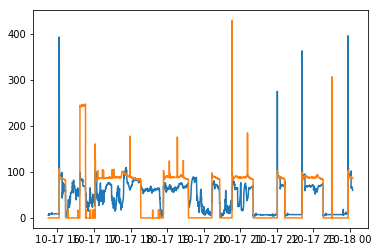

In [22]:
pred, gr = predict.align(ground,join ='inner')
plt.plot(pred[10000:15000])
plt.plot(gr[10000:15000])